# Binary Classification of NSL-KDD IDS Dataset

## Method used - Ensemble Stacking 

### Paper reference1 - A Stacking Ensemble for Network Intrusion Detection Using Heterogeneous Datasets https://www.hindawi.com/journals/scn/2020/4586875/

### Paper reference2 - Anomaly Detection Using XGBoost Ensemble of Deep Neural Network Models https://sciendo.com/article/10.2478/cait-2020-0037

### Implemented By - Sarvesh Sridhar 19BAI1057

#### Proposed Method in Paper Reference1-
Stacking of sub-classifier(RandomForest, Logistic Regression, KNN) with meta-classifier (SVM)

#### Proposed Method in Paper Reference2 - 
Stacking of sub-classifiers(LSTM,BackPropagation, MLP) with meta-classifier (XGBoost)

#### Method implemented in this notebook - 
Stacking of sub-classifiers(Decision Tree, KNN, Random Forest, GaussianNaive Bayes) with meta-classifier (XGBoost + RandomForest)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
import itertools
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import GridSearchCV
import h5py
import tensorflow as tf
import lightgbm as lg
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.metrics import plot_confusion_matrix

In [ ]:
col = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train = pd.read_csv('KDDTrain+_20Percent.txt', header = None)
test = pd.read_csv('KDDTest+.txt', header = None)

train.columns = col
test.columns = col

### Preprocessing

1) We add new column "class" which says if the traffic is normal or abnormal

2) We drop "attack" and "level" from dataset

3) We normalize the numeric data with StandardScaler where the data has mean = 0 and standard deviation = 1

4) We label the categorical data with LabelEncoder where data is given labels 

5) Returns the "x_train" which is normalized numeric data and label encoded categorical data

In [ ]:
def preprocessing1(df):
    
    # ADDING "IS_ATTACK" --> says if the traffic is normal or abnormal
    df_is_attack = df.attack.map(lambda x:0 if x == 'normal' else 1)
    df['class'] = df_is_attack
    df.drop('attack',axis = 1, inplace = True)
    df.drop('level',axis = 1, inplace = True)
    
    # STANDARD SCALER --> numeric data --> normalization
    scaler = StandardScaler()
    cols = df.select_dtypes(include=['float64','int64']).columns
    cols = np.array(cols)

    cols = np.delete(cols, len(cols)-1)
    cols = np.delete(cols, len(cols)-1)

    df_scaled = scaler.fit_transform(df[cols])
    df_scaled = pd.DataFrame(df_scaled, columns = cols)
    
    # ENCODING CATEGORICAL FEATURES --> PROTOCOL, SERVICE, FLAG
    encoder = LabelEncoder()

    # extract categorical attributes from both training and test sets 
    catdf = df.select_dtypes(include=['object']).copy()

    # encode the categorical attributes
    dfcat = catdf.apply(encoder.fit_transform)
    
    # concat x_train, y_train
    x_train = pd.concat([df_scaled, dfcat], axis = 1)
    y_train = df['class']
    
    return x_train, y_train

In [ ]:
x_train, y_train = preprocessing1(train)
x_test, y_test = preprocessing1(test)

x_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
x_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

print("Shape of x_train",x_train.shape)
print("Shape of y_train",y_train.shape)
print("Shape of x_test",x_test.shape)
print("Shape of y_test",y_test.shape)

Shape of x_train (25192, 39)
Shape of y_train (25192,)
Shape of x_test (22544, 39)
Shape of y_test (22544,)


In [ ]:
train_accuracy = []
test_accuracy = []
model = []

### KNN

In [ ]:
# neighbors =5
knn2 = KNeighborsClassifier(n_neighbors = 5).fit(x_train, y_train)

y_knn_test_pred = knn2.predict(x_test)
y_knn_train_pred = knn2.predict(x_train)

train_acc = accuracy_score(y_train, y_knn_train_pred)
test_acc = accuracy_score(y_test, y_knn_test_pred)

print("Accuracy - KNN- train:", train_acc)
print("Accuracy - KNN - test: ", test_acc)

Accuracy - KNN- train: 0.9951174976182915
Accuracy - KNN - test:  0.7911195883605394


In [ ]:
model.append('KNN')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

In [ ]:
# SAVE KNN MODEL --> KNN2
import pickle
# with open('knn_model','wb') as f:
#     pickle.dump(knn2, f)

### Random Forest Classifier

#### We try to find best parameters for Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf_parameters = {
    'n_estimators':[int(x) for x in np.linspace(start = 10, stop = 80, num = 10)],
    'max_features':['auto', 'sqrt'],
    'max_depth' :[2,4],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [1,2],
    'bootstrap' : [True, False]
}
grid1 = GridSearchCV(rf, rf_parameters)
grid1.fit(x_train, y_train)
print()

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=41; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=64; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=64; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=64; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=64; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=41; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=41; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=41; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=56; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=72; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=33; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_s

[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.8s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_s

[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=aut

[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=aut

[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=48; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=56; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=64; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=aut

[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.6s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=72; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=aut

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqr

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqr

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=41; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.5s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=56; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=sqr

[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=64; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=72; total time=   1.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=72; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=aut

[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   0.9s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.1s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, max_features=aut

[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=17; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=17; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, max_features=aut

[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33; total time=   0.4s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.4s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.4s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.4s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.4s
[CV] END bootstrap=False, max_depth=4, max_features=sqr

[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=48; total time=   0.5s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.6s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.5s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.5s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.6s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.6s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=sqr

[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time=   0.7s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time=   0.9s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   1.0s
[CV] END bootstrap=False, max_depth=4, max_features=sqr

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [ ]:
best_params_rf = grid1.best_params_
best_params_rf

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 48}

In [ ]:
y_test_pred = grid1.predict(x_test)
y_train_pred = grid1.predict(x_train)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print("Accuracy - grid- train:", train_acc)
print("Accuracy - grid - test: ", test_acc)

Accuracy - grid- train: 0.9781279771355986
Accuracy - grid - test:  0.791208303761533


#### Running the RFClassifier with best parameters

In [ ]:
best_rf = RandomForestClassifier(bootstrap = True,
                                 max_depth= 4,
                                 max_features= 'sqrt',
                                 min_samples_leaf= 2,
                                 min_samples_split= 2,
                                 n_estimators= 48)
best_rf.fit(x_train, y_train)

y_rf_test_pred = best_rf.predict(x_test)
y_rf_train_pred = best_rf.predict(x_train)
train_acc = accuracy_score(y_train, y_rf_train_pred)
test_acc = accuracy_score(y_test, y_rf_test_pred)
print("Accuracy - best_rf- train:", train_acc)
print("Accuracy - best_rf - test: ", test_acc)

Accuracy - best_rf- train: 0.9780485868529692
Accuracy - best_rf - test:  0.7763928317955997


In [ ]:
model.append('Random Forest')
train_accuracy.append(accuracy_score(y_train, y_rf_train_pred))
test_accuracy.append(accuracy_score(y_test, y_rf_test_pred))

In [ ]:
# with open('rf_model','wb') as f:
#     pickle.dump(best_rf, f)

### Decision Tree Classifier

In [ ]:
dc = DecisionTreeClassifier()
dc.fit(x_train, y_train)

y_dc_test_pred = dc.predict(x_test)
y_dc_train_pred = dc.predict(x_train)
train_acc = accuracy_score(y_train, y_dc_train_pred)
test_acc = accuracy_score(y_test, y_dc_test_pred)
print("Accuracy - best_dc- train:", train_acc)
print("Accuracy - best_dc - test: ", test_acc)

Accuracy - best_dc- train: 0.9999603048586853
Accuracy - best_dc - test:  0.8212384669978708


In [ ]:
model.append('Decision Tree')
train_accuracy.append(accuracy_score(y_train, y_dc_train_pred))
test_accuracy.append(accuracy_score(y_test, y_dc_test_pred))

### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)

y_nb_test_pred = nb.predict(x_test)
y_nb_train_pred = nb.predict(x_train)
train_acc = accuracy_score(y_train, y_nb_train_pred)
test_acc = accuracy_score(y_test, y_nb_test_pred)
print("Accuracy - best_dc- train:", train_acc)
print("Accuracy - best_dc - test: ", test_acc)

Accuracy - best_dc- train: 0.8906001905366783
Accuracy - best_dc - test:  0.5689318665720369


In [ ]:
model.append('Naive Bayes')
train_accuracy.append(accuracy_score(y_train, y_nb_train_pred))
test_accuracy.append(accuracy_score(y_test, y_nb_test_pred))

### Artificial Neural Network

In [ ]:
ann = keras.Sequential()
ann.add(layers.Dense(60, activation = 'relu', input_shape = (x_train.shape[1],)))
ann.add(layers.Dense(120, activation = 'relu'))
ann.add(layers.Dense(60, activation = 'relu'))
ann.add(layers.Dense(1, activation = 'sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                2400      
                                                                 
 dense_5 (Dense)             (None, 120)               7320      
                                                                 
 dense_6 (Dense)             (None, 60)                7260      
                                                                 
 dense_7 (Dense)             (None, 1)                 61        
                                                                 
Total params: 17,041
Trainable params: 17,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/GPU:0'):
    ann.fit(x_train, y_train, batch_size = 20, epochs = 10)

Epoch 1/10
1260/1260 [==============================] - 13s 7ms/step - loss: 0.1118 - accuracy: 0.9577
Epoch 2/10
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0552 - accuracy: 0.9796
Epoch 3/10
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0424 - accuracy: 0.9842: 1s - loss: 0.0416 - ac
Epoch 4/10
1260/1260 [==============================] - 15s 12ms/step - loss: 0.0371 - accuracy: 0.9860
Epoch 5/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0323 - accuracy: 0.9870
Epoch 6/10
1260/1260 [==============================] - 8s 7ms/step - loss: 0.0296 - accuracy: 0.9887
Epoch 7/10
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0284 - accuracy: 0.9890
Epoch 8/10
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0259 - accuracy: 0.9906: 0s - loss:
Epoch 9/10
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0254 - accuracy: 0.9909: 0s - loss: 0.0255 - accuracy: 0.
Epoch 10/

In [ ]:
y_ann_test_pred = ann.predict(x_test)
y_ann_train_pred = ann.predict(x_train)

y_ann_test_pred = (y_test_pred > 0.5)
y_ann_train_pred = (y_train_pred > 0.5)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Accuracy - ann- train:", train_acc)
print("Accuracy - ann - test: ", test_acc)

Accuracy - ann- train: 0.9780485868529692
Accuracy - ann - test:  0.7763928317955997


In [ ]:
model.append('Artificial Neural Networks')
train_accuracy.append(accuracy_score(y_train, y_ann_train_pred))
test_accuracy.append(accuracy_score(y_test, y_ann_test_pred))

In [ ]:
# ann.save('ann_model.h5')

### BackPropagation Technique

In [ ]:
input_dim = x_train.shape[1]
input_dim

39

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam

bp = keras.Sequential()
bp.add(layers.Dense(78, input_dim = x_train.shape[1]))
bp.add(Activation('relu'))
bp.add(layers.Dense(78*2))
bp.add(Activation('relu'))
bp.add(layers.Dense(78))
bp.add(Activation('sigmoid'))
bp.add(Dense(1))

bp.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
with tf.device('/GPU:0'):
    bp.fit(x_train, y_train, batch_size = 40, epochs = 10)

Epoch 1/10
630/630 [==============================] - 7s 10ms/step - loss: 0.0381 - accuracy: 0.9570
Epoch 2/10
630/630 [==============================] - 6s 10ms/step - loss: 0.0184 - accuracy: 0.9808
Epoch 3/10
630/630 [==============================] - 6s 10ms/step - loss: 0.0129 - accuracy: 0.9875
Epoch 4/10
630/630 [==============================] - 7s 11ms/step - loss: 0.0108 - accuracy: 0.9881
Epoch 5/10
630/630 [==============================] - 6s 10ms/step - loss: 0.0099 - accuracy: 0.9890
Epoch 6/10
630/630 [==============================] - 6s 10ms/step - loss: 0.0088 - accuracy: 0.9902
Epoch 7/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0082 - accuracy: 0.9909
Epoch 8/10
630/630 [==============================] - 5s 8ms/step - loss: 0.0076 - accuracy: 0.9919
Epoch 9/10
630/630 [==============================] - 6s 10ms/step - loss: 0.0073 - accuracy: 0.9924
Epoch 10/10
630/630 [==============================] - 7s 10ms/step - loss: 0.0066 - accuracy

In [ ]:
y_bp_test_pred = bp.predict(x_test)
y_bp_train_pred = bp.predict(x_train)

y_bp_test_pred = (y_test_pred > 0.5)
y_bp_train_pred = (y_train_pred > 0.5)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Accuracy - bp- train:", train_acc)
print("Accuracy - bp - test: ", test_acc)

Accuracy - bp- train: 0.9780485868529692
Accuracy - bp - test:  0.7763928317955997


In [ ]:
bp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 78)                3120      
                                                                 
 activation_7 (Activation)   (None, 78)                0         
                                                                 
 dense_21 (Dense)            (None, 156)               12324     
                                                                 
 activation_8 (Activation)   (None, 156)               0         
                                                                 
 dense_22 (Dense)            (None, 78)                12246     
                                                                 
 activation_9 (Activation)   (None, 78)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [ ]:
model.append('BackPropogation Neural Network')
train_accuracy.append(accuracy_score(y_train, y_bp_train_pred))
test_accuracy.append(accuracy_score(y_test, y_bp_test_pred))

In [ ]:
# bp.save('bpnn.h5')

### Models conclusion

In [ ]:
result = pd.DataFrame(index=model)
result['Train'] = train_accuracy
result['Test'] = test_accuracy
result.head()

NameError: ignored

## Stacking Method

### Define sub-classifiers and meta-classifier

In [ ]:
with open('knn_model','rb') as f:
    clf1 = pickle.load(f)
with open('rf_model', 'rb') as f:
    clf2 = pickle.load(f)
clf5 = dc
clf6 = nb

### Meta classifier - XG Random Forest Classifier

Sub classifiers - KNN, RandomForest, Decision Tree, Naive Bayes

In [ ]:
meta_classifier = xgboost.XGBRFClassifier(eval_metric=accuracy_score)

stack_classifier = StackingClassifier(classifiers = [clf1,clf2,clf5,clf6], meta_classifier = meta_classifier)
stack_classifier.fit(x_train, y_train)
print()
predicted_train = stack_classifier.predict(x_train)
predicted_test = stack_classifier.predict(x_test)

print("Accuracy: train: ",accuracy_score(predicted_train, y_train))
print("Accuracy-test: ", accuracy_score(predicted_test, y_test))

[15:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy: train:  0.9999603048586853
Accuracy-test:  0.8367193044712562


In [ ]:
# with open('stacked_model','wb') as f:
#     pickle.dump(stack_classifier, f)

In [ ]:
clf3 = tf.keras.models.load_model('ann_model.h5')
clf4 = tf.keras.models.load_model('bpnn.h5')

accuracy_meta_train = accuracy_score(predicted_train, y_train)
accuracy_meta_test = accuracy_score(predicted_test, y_test)

model.append("Stacking(XGBoost, RandomForest)")
train_accuracy.append(accuracy_meta_train)
test_accuracy.append(accuracy_meta_test)

### Manually creating a dataset for meta classifier

In [ ]:
y_ann_train_pred_int = [int(i) for i in y_ann_train_pred]
y_bp_train_pred_int = [int(i) for i in y_bp_train_pred]
y_ann_test_pred_int = [int(i) for i in y_ann_test_pred]
y_bp_test_pred_int = [int(i) for i in y_bp_test_pred]

x1_train = pd.DataFrame()

x1_train['knn'] = y_knn_train_pred
x1_train['rf'] = y_rf_train_pred
x1_train['ann'] = y_ann_train_pred_int
x1_train['bp'] = y_bp_train_pred_int
x1_train['dc'] = y_dc_train_pred
x1_train['nb'] = y_nb_train_pred

x1_test = pd.DataFrame()

x1_test['knn'] = y_knn_test_pred
x1_test['rf'] = y_rf_test_pred
x1_test['ann'] = y_ann_test_pred_int
x1_test['bp'] = y_bp_test_pred_int
x1_test['dc'] = y_dc_test_pred
x1_test['nb'] = y_nb_test_pred

### Meta classifier - XGBoost
### Sub-classifiers - KNN, RandomForest, ANN, BackPropagation

In [ ]:
# KNN,RF,ANN,BP
meta_classifier = XGBClassifier()
meta_classifier.fit(x1_train, y_train)
y_meta_train_pred = meta_classifier.predict(x1_train)
y_meta_test_pred = meta_classifier.predict(x1_test)

print("Accuracy - Stacking models - train: ", accuracy_score(y_meta_train_pred, y_train))
print("Accuracy - Stacking models - test: ", accuracy_score(y_meta_test_pred, y_test))

[14:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy - Stacking models - train:  0.9951174976182915
Accuracy - Stacking models - test:  0.7911195883605394


### Meta classifier - XGBoost

### Sub-classifier - KNN, Random Forest, ANN, BP, Decision Trees, Gaussian Bayes

In [ ]:
# new --> KNN,RF,ANN,BP,DT,NB
meta_classifier = XGBClassifier()
meta_classifier.fit(x1_train, y_train)
y_meta_train_pred = meta_classifier.predict(x1_train)
y_meta_test_pred = meta_classifier.predict(x1_test)

print("Accuracy - Stacking models - train: ", accuracy_score(y_meta_train_pred, y_train))
print("Accuracy - Stacking models - test: ", accuracy_score(y_meta_test_pred, y_test))

[14:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy - Stacking models - train:  0.9999603048586853
Accuracy - Stacking models - test:  0.8212384669978708


### Dataset creation with only KNN, ANN, Decision Tree

### Meta-classifier - XGboost

### Sub-classifier - KNN,ANN, Decision Tree

In [ ]:
# KNN,ANN,DT
x2_train = pd.DataFrame()
x2_test = pd.DataFrame()

x2_train['knn'] = y_knn_train_pred
x2_train['ann'] = y_ann_train_pred_int
x2_train['dc'] = y_dc_train_pred

x2_test['knn'] = y_knn_test_pred
x2_test['ann'] = y_ann_test_pred_int
x2_test['dc'] = y_dc_test_pred

meta_classifier3 = XGBClassifier()
meta_classifier3.fit(x2_train, y_train)
y_meta_train_pred3 = meta_classifier3.predict(x2_train)
y_meta_test_pred3 = meta_classifier3.predict(x2_test)

print("Accuracy - Stacking models - train: ", accuracy_score(y_meta_train_pred3, y_train))
print("Accuracy - Stacking models - test: ", accuracy_score(y_meta_test_pred3, y_test))

[15:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy - Stacking models - train:  0.9999603048586853
Accuracy - Stacking models - test:  0.8212384669978708


### Performace

In [ ]:
performace = pd.DataFrame(index=model)
performace['Train'] = train_accuracy
performace['Test'] = test_accuracy
performace

,Train,Test
KNN,0.995117,0.791120
Random Forest,0.981939,0.762420
Decision Tree,0.999960,0.821238
Naive Bayes,0.890600,0.568932
Artificial Neural Networks,0.978049,0.776393
BackPropogation Neural Network,0.978049,0.776393
"Stacking(XGBoost, RandomForest)",0.999960,0.836719


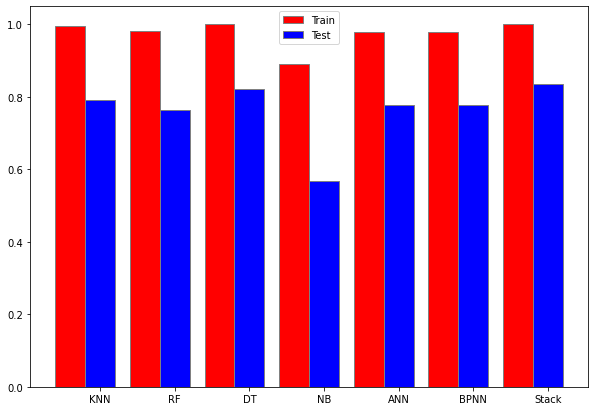

In [ ]:
# set width of bar
barWidth = 0.4
fig = plt.subplots(figsize =(10,7))
model1 = ['KNN','RF','DT','NB','ANN','BPNN','Stack']
train_perf = performace["Train"].values
test_perf = performace["Test"].values
# Make the plot

bar1 = np.arange(len(model1))
br2 = [x + barWidth for x in br1]

plt.bar(bar1, train_perf, label="Train", width = barWidth, edgecolor ='grey',color = 'r')
plt.bar(bar2, test_perf, label="Test", width = barWidth, edgecolor ='grey',color ='b')

plt.xticks([r + barWidth for r in range(len(model1))],model1)
plt.legend()

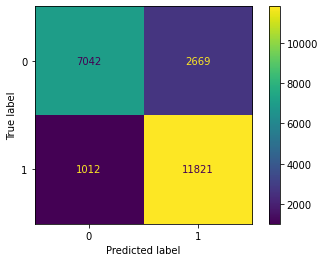

In [ ]:
plot_confusion_matrix(stack_classifier, x_test, y_test)